# CS 109B Advanced Topics in Data Science, Final Project, Milestone 4

## Group 9 - Steve Robbins, Chad Tsang, and Ted Heuer
**Harvard University**<br>
**Spring 2017**<br>
**Due Date: ** Wednesday, April 12th, 2017 at 11:59pm

### Milestone 4: Deep learning, due Wednesday, April 26, 2017

For this milestone you will (finally) use deep learning to predict movie genres. You will train one small network from scratch on the posters only, and compare this one to a pre-trained network that you fine tune. [Here](https://keras.io/getting-started/faq/#how-can-i-use-pre-trained-models-in-keras) is a description of how to use pretrained models in Keras.

You can try different architectures, initializations, parameter settings, optimization methods, etc. Be adventurous and explore deep learning! It can be fun to combine the features learned by the deep learning model with a SVM, or incorporate meta data into your deep learning model. 

**Note:** Be mindful of the longer training times for deep models. Not only for training time, but also for the parameter tuning efforts. You need time to develop a feel for the different parameters and which settings work, which normalization you want to use, which model architecture you choose, etc. 

It is great that we have GPUs via AWS to speed up the actual computation time, but you need to be mindful of your AWS credits. The GPU instances are not cheap and can accumulate costs rather quickly. Think about your model first and do some quick dry runs with a larger learning rate or large batch size on your local machine. 

The notebook to submit this week should at least include:

- Complete description of the deep network you trained from scratch, including parameter settings, performance, features learned, etc. 
- Complete description of the pre-trained network that you fine tuned, including parameter settings, performance, features learned, etc. 
- Discussion of the results, how much improvement you gained with fine tuning, etc. 
- Discussion of at least one additional exploratory idea you pursued

### Useful links - Delete or cite these.
https://keras.io/callbacks/

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

https://keras.io/getting-started/faq/#how-can-i-use-keras-with-datasets-that-dont-fit-in-memory

https://elitedatascience.com/keras-tutorial-deep-learning-in-python#step-4

http://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/

In [1]:
#!pip install keras 
#!pip install tensorflow
#!pip install tensorflow.python

In [2]:
from __future__ import print_function
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import numpy as np
import pandas as pd
from scipy import misc

In [3]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
from keras import backend as K

Using TensorFlow backend.


### Settings

### Load, split, and prepare the data.

In [4]:
def load_poster_data(image_size, source_size = 'w92', verbose = False):
    # Loads the poster image data at the requested size, the assigned genre, and the movie id.
    #
    y_labels = pd.read_csv('y_labels_multiclass.csv')
    image_path = './posters/' + source_size + '/'
    posters = pd.DataFrame()
    for movie in y_labels.iterrows():
        row = movie[0]
        movie_id = movie[1]['movie_id']
        genre_id = int(movie[1]['genre_id'].replace('[', '').replace(']',''))
        try:
            image = misc.imread(image_path + str(movie_id) + '.jpg')
            image_resize = img_to_array(misc.imresize(image, image_size))
            if (image_resize.shape[2]==3):
                posters = posters.append({'movie_id' : movie_id, 
                                          'genre_id' : genre_id,
                                          'poster' : image_resize}, ignore_index = True)
        except IOError:
            if (verbose == True):
                print('Unable to load poster for movie #', movie_id)
    print('Loaded ', posters.shape[0], ' posters.')
    return posters

In [5]:
def stratified_sampler(dataset, observations):
    # Performs a stratified sample on the dataset and returns the number of observations 
    # requested.
    #
    # Parameters:
    #    dataset:  The dataframe to sample, observing class relationships.
    #    observations:  The number of total target observations across all classes.
    #
    # Returns:
    #    A pandas dataframe sampled from the dataset maintaining class relationships.
    class_weights = dataset.groupby("genre_id").agg(['count'])/len(dataset)
    class_sample_counts = class_weights * observations
    class_count = class_weights.shape[0]
    sampled = pd.DataFrame()
    for class_to_sample in class_sample_counts.iterrows():
        class_name = class_to_sample[0]
        desired_class_observations = class_to_sample[1][0]
        sampled_obs = dataset[dataset["genre_id"]==class_name].sample(int(desired_class_observations), replace="True")
        sampled = sampled.append(sampled_obs, ignore_index=True)
    return sampled, class_count

In [6]:
def reshape_and_normalize(data):
    image_count = data.shape[0]
    temp = np.ndarray(shape=(image_count, data[0].shape[0], data[0].shape[1], 3))

    for index in range(0, image_count):
        try:
            temp[index] = data[index].reshape(data[0].shape[0], data[0].shape[1], 3)
        except ValueError:
            print(data[index].shape)
    temp = temp.astype('float32')
    temp /= 255.0

    return temp

In [7]:
def normalize_responses(data):
    unique_responses = np.sort(data["genre_id"].unique())
    data["genre_id"] = data["genre_id"].replace(unique_responses, range(0,len(unique_responses)), inplace=False)
    return data

In [8]:
def load_split_prepare_data(train_observations, test_observations, image_size, sample = 'stratified'):
    # Loads, splits, and prepares the data for use by a CNN model.
    #
    # Parameters:
    #    train_observations:  The dataframe to sample, observing class relationships.
    #    test_observations:  The number of total target observations across all classes.
    #    sample:  The sampling method, currently only supports 'stratified'
    #
    # Returns:
    #    Nothing.
    posters_data = load_poster_data(image_size)
    posters = normalize_responses(posters_data)
    
    if (sample == 'stratified'):
        train_sample, class_count_train = stratified_sampler(posters, train_observations)
        test_sample, class_count_test = stratified_sampler(posters, test_observations)
    else:
        raise('Unsupported sample method : ', sample)
         
    x_train = train_sample["poster"]
    y_train = train_sample["genre_id"]
    x_test = test_sample["poster"]
    y_test = test_sample["genre_id"]

    img_rows = x_train[0].shape[0]
    img_cols = x_train[0].shape[1]
    print('Classes : ', class_count_train)
        
    x_train = reshape_and_normalize(x_train)
    x_test = reshape_and_normalize(x_test)

    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    # Convert response to one hot encoding
    y_train = keras.utils.to_categorical(y_train, class_count_train)
    y_test = keras.utils.to_categorical(y_test, class_count_test)

    return (x_train, y_train), (x_test, y_test), class_count_train

In [9]:
(x_train, y_train), (x_test, y_test), classes = load_split_prepare_data(train_observations = 5000, 
                                                                        test_observations = 1000, 
                                                                        image_size = (138,92), 
                                                                        sample='stratified')

Loaded  3927  posters.
Classes :  7
x_train shape: (4996, 138, 92, 3)
4996 train samples
997 test samples


### Create the Convolutional Neural Net architecture, from scratch.

In [10]:
classes = 7
final_activation_function = 'softmax'

input_activation_function = 'relu'
input_kernel_size = (5,5)
input_shape = (138, 92, 3)
pool_size = (3,3)

hidden_activation_function = 'relu'
hidden_kernel_size = (3,3)

loss_method = 'categorical_crossentropy'
optimizer = SGD(lr=0.1, momentum=0.9)
eval_metric = 'accuracy'

# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 256
# number of iterations over the complete training data
epochs = 200

In [11]:
# create an empty network model
model = Sequential()

# Input Layer
model.add(Conv2D(16, kernel_size=input_kernel_size, activation=input_activation_function, input_shape=input_shape))
model.add(MaxPooling2D(pool_size=pool_size))

# Hidden Layer(s)
model.add(Conv2D(32, kernel_size=hidden_kernel_size, activation=hidden_activation_function))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=pool_size))

# Adding another layer did not improve performance, perhaps because of the pooling on pooling.
#model.add(Conv2D(48, kernel_size=hidden_kernel_size, activation=hidden_activation_function))
#model.add(Dropout(0.25))
#model.add(MaxPooling2D(pool_size=pool_size))

# Classification layer
model.add(Flatten())
model.add(Dense(64, activation=hidden_activation_function))
model.add(Dropout(0.5))
model.add(Dense(classes, activation=final_activation_function))

# Display the CNN.
model.summary()

# Compile the model.
model.compile(loss=loss_method, optimizer=optimizer, metrics=[eval_metric])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 134, 88, 16)       1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 29, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 27, 32)        4640      
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 27, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 9, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4032)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                258112    
__________

### Train the CNN.

In [12]:
# The actual training of the CNN using the parameters and model previously specified.
# The validation set is a split of the stratified sampled training data.
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split = 0.15)

# Evaluate the performance on the unused testing set.
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 4246 samples, validate on 750 samples
Epoch 1/200
4246/4246 [==============================] - 47s - loss: 1.6710 - acc: 0.2862 - val_loss: 4.6371 - val_acc: 0.0000e+00
Epoch 2/200
4246/4246 [==============================] - 46s - loss: 1.5130 - acc: 0.3754 - val_loss: 5.0491 - val_acc: 0.0000e+00
Epoch 3/200
4246/4246 [==============================] - 45s - loss: 1.5057 - acc: 0.3620 - val_loss: 5.2226 - val_acc: 0.0000e+00
Epoch 4/200
4246/4246 [==============================] - 45s - loss: 1.4251 - acc: 0.4091 - val_loss: 6.1261 - val_acc: 0.0000e+00
Epoch 5/200
4246/4246 [==============================] - 44s - loss: 1.3611 - acc: 0.4277 - val_loss: 5.1586 - val_acc: 0.0000e+00
Epoch 6/200
4246/4246 [==============================] - 44s - loss: 1.3344 - acc: 0.4477 - val_loss: 6.5343 - val_acc: 0.0000e+00
Epoch 7/200
4246/4246 [==============================] - 44s - loss: 1.2504 - acc: 0.4873 - val_loss: 7.3032 - val_acc: 0.0000e+00
Epoch 8/200
4246/4246 [=============

In [13]:
model.save_weights('tuned_weights.h5')

In [14]:
model.layers

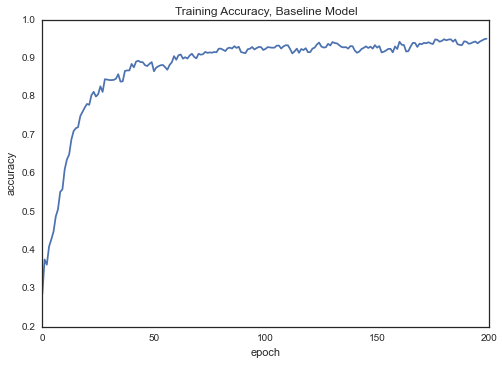

In [27]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Training Accuracy, Baseline Model");

From the above, we see that this model with 200 epochs (which includes some slight tuning) yielded an impressive accuracy of 70% on the unseen test set, and 95% accuracy on the training set.  Next, we will add another convultional, dropout, and pooling layer and see the results.

In [19]:
# create an empty network model
model2 = Sequential()

# Input Layer
model2.add(Conv2D(16, kernel_size=input_kernel_size, activation=input_activation_function, input_shape=input_shape))
model2.add(MaxPooling2D(pool_size=pool_size))

# Hidden Layer(s)
model2.add(Conv2D(32, kernel_size=hidden_kernel_size, activation=hidden_activation_function))
model2.add(Dropout(0.25))
model2.add(MaxPooling2D(pool_size=pool_size))

model2.add(Conv2D(48, kernel_size=hidden_kernel_size, activation=hidden_activation_function))
model2.add(Dropout(0.25))
model2.add(MaxPooling2D(pool_size=pool_size))

# Classification layer
model2.add(Flatten())
model2.add(Dense(64, activation=hidden_activation_function))
model2.add(Dropout(0.5))
model2.add(Dense(classes, activation=final_activation_function))

# Display the CNN.
model2.summary()

# Compile the model.
model2.compile(loss=loss_method, optimizer=optimizer, metrics=[eval_metric])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, 134, 88, 16)       1216      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 44, 29, 16)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 42, 27, 32)        4640      
_________________________________________________________________
dropout_3 (Dropout)          (None, 42, 27, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 9, 32)         0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 12, 7, 48)         13872     
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 7, 48)         0         
__________

In [20]:
# The actual training of the CNN using the parameters and model previously specified.
# The validation set is a split of the stratified sampled training data.
history2 = model2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split = 0.15)

# Evaluate the performance on the unused testing set.
score2 = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

Train on 4246 samples, validate on 750 samples
Epoch 1/200
4246/4246 [==============================] - 48s - loss: 1.6543 - acc: 0.2812 - val_loss: 4.9307 - val_acc: 0.0000e+00
Epoch 2/200
4246/4246 [==============================] - 47s - loss: 1.5931 - acc: 0.3069 - val_loss: 4.0383 - val_acc: 0.0000e+00
Epoch 3/200
4246/4246 [==============================] - 46s - loss: 1.5346 - acc: 0.3420 - val_loss: 4.1623 - val_acc: 0.0000e+00
Epoch 4/200
4246/4246 [==============================] - 46s - loss: 1.4778 - acc: 0.3846 - val_loss: 4.7397 - val_acc: 0.0000e+00
Epoch 5/200
4246/4246 [==============================] - 46s - loss: 1.4699 - acc: 0.3815 - val_loss: 5.1063 - val_acc: 0.0000e+00
Epoch 6/200
4246/4246 [==============================] - 46s - loss: 1.4468 - acc: 0.4103 - val_loss: 5.3261 - val_acc: 0.0000e+00
Epoch 7/200
4246/4246 [==============================] - 46s - loss: 1.4355 - acc: 0.4178 - val_loss: 4.9961 - val_acc: 0.0000e+00
Epoch 8/200
4246/4246 [=============

In [21]:
model2.save_weights('tuned_weights2.h5')

In [22]:
model2.layers

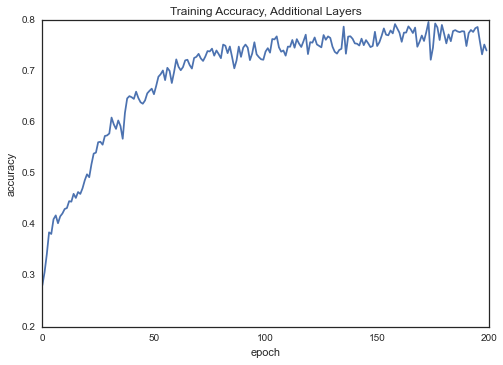

In [28]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.plot(history2.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Training Accuracy, Additional Layers");

From the above results, we see that this model with 250 epochs and nother convultional, dropout, and pooling layer  yielded an accuracy of ~60% on the unseen test set, and 75% accuracy on the training set.  This is a reduction of 20% accuracy on the training set and a 10% reduction on the test set, from the previous, simpler model.  It is believed that the addition of the convolutional layer and pooling layer are simplifing the details of the image excessively and loosing detail.

### Tune an existing CNN.

In [16]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)

# this is the model we will train
model_tune = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model_tune.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [17]:
model_tune.layers

In [18]:
# train the model on the new data for a few epochs
# fine-tune the model
tune_history = model_tune.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split = 0.15)

ValueError: Error when checking model target: expected dense_4 to have shape (None, 200) but got array with shape (4996, 7)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(...)